In [1]:
from time import time
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

In [2]:
df = pd.read_csv('data/stocks.csv')

In [3]:
df

,date,close,high,low,open,volume,ticker,dollar_vol,dollar_vol_1m,dollar_vol_rank,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2015-07-06,38.426975,38.504885,38.046083,38.054738,23034000,MSFT,8.851269e+08,4.491610e+09,1.0,...,False,False,False,False,True,False,False,False,False,False
1,2015-07-07,38.349068,38.513547,37.500714,38.383695,36435800,MSFT,1.397279e+09,4.547745e+09,1.0,...,False,False,False,False,True,False,False,False,False,False
2,2015-07-08,38.297127,38.868467,38.115334,38.470258,39785900,MSFT,1.523686e+09,4.578243e+09,1.0,...,False,False,False,False,True,False,False,False,False,False
3,2015-07-09,38.539524,39.145492,38.522210,38.738627,32424700,MSFT,1.249633e+09,4.675900e+09,1.0,...,False,False,False,False,True,False,False,False,False,False
4,2015-07-10,38.617428,39.076231,38.582800,38.963693,25465800,MSFT,9.834237e+08,4.783547e+09,1.0,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21316,2024-11-22,229.056870,229.903869,227.253275,227.253275,38168300,AAPL,8.742711e+09,3.370178e+10,1.0,...,False,False,False,False,False,False,False,False,True,False
21317,2024-11-25,232.046249,232.424910,228.927332,230.641249,90152800,AAPL,2.091962e+10,3.317622e+10,1.0,...,False,False,False,False,False,False,False,False,True,False
21318,2024-11-26,234.228500,234.736706,232.504624,232.504624,45986200,AAPL,1.077128e+10,3.283385e+10,1.0,...,False,False,False,False,False,False,False,False,True,False
21319,2024-11-27,234.098953,234.856275,232.982920,233.640589,33498400,AAPL,7.841940e+09,3.275652e+10,1.0,...,False,False,False,False,False,False,False,False,True,False


In [4]:
df.columns

Index(['date', 'close', 'high', 'low', 'open', 'volume', 'ticker',
       'dollar_vol', 'dollar_vol_1m', 'dollar_vol_rank', 'rsi', 'bb_high',
       'bb_low', 'atr', 'macd', 'return_1d', 'return_5d', 'return_10d',
       'return_21d', 'return_42d', 'return_63d', 'lag_return_1d',
       'lag_return_5d', 'lag_return_10d', 'lag_return_21d', 'target_1d',
       'target_5d', 'target_10d', 'target_21d', 'year_2016', 'year_2017',
       'year_2018', 'year_2019', 'year_2020', 'year_2021', 'year_2022',
       'year_2023', 'year_2024', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12'],
      dtype='object')

In [5]:
columns_to_drop = [c for c in df.columns if 'lag' in c] + ['open', 'close', 'high', 'low', 'dollar_vol', 'dollar_vol_rank', 'volume'] + [c for c in df.columns if 'year' in c] + [c for c in df.columns if 'month' in c]
print(f"Columns to drop: {columns_to_drop}")
print(f"Available columns: {list(df.columns)}")

# Only drop columns that actually exist
existing_lag_columns = [c for c in columns_to_drop if c in df.columns]
if existing_lag_columns:
    df = df.drop(existing_lag_columns, axis=1)
    print(f"Dropped {len(existing_lag_columns)} columns")
else:
    print("No lag columns found to drop")

Columns to drop: ['lag_return_1d', 'lag_return_5d', 'lag_return_10d', 'lag_return_21d', 'open', 'close', 'high', 'low', 'dollar_vol', 'dollar_vol_rank', 'volume', 'year_2016', 'year_2017', 'year_2018', 'year_2019', 'year_2020', 'year_2021', 'year_2022', 'year_2023', 'year_2024', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']
Available columns: ['date', 'close', 'high', 'low', 'open', 'volume', 'ticker', 'dollar_vol', 'dollar_vol_1m', 'dollar_vol_rank', 'rsi', 'bb_high', 'bb_low', 'atr', 'macd', 'return_1d', 'return_5d', 'return_10d', 'return_21d', 'return_42d', 'return_63d', 'lag_return_1d', 'lag_return_5d', 'lag_return_10d', 'lag_return_21d', 'target_1d', 'target_5d', 'target_10d', 'target_21d', 'year_2016', 'year_2017', 'year_2018', 'year_2019', 'year_2020', 'year_2021', 'year_2022', 'year_2023', 'year_2024', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 

In [6]:
df.columns

Index(['date', 'ticker', 'dollar_vol_1m', 'rsi', 'bb_high', 'bb_low', 'atr',
       'macd', 'return_1d', 'return_5d', 'return_10d', 'return_21d',
       'return_42d', 'return_63d', 'target_1d', 'target_5d', 'target_10d',
       'target_21d'],
      dtype='object')

In [7]:
df.set_index(['ticker', 'date'], inplace=True)

Now we have to split our data into train and test sets.

### Split

In [8]:
dates_available = df.index.get_level_values('date').unique()
dates_available

Index(['2015-07-06', '2015-07-07', '2015-07-08', '2015-07-09', '2015-07-10',
       '2015-07-13', '2015-07-14', '2015-07-15', '2015-07-16', '2015-07-17',
       ...
       '2024-11-15', '2024-11-18', '2024-11-19', '2024-11-20', '2024-11-21',
       '2024-11-22', '2024-11-25', '2024-11-26', '2024-11-27', '2024-11-29'],
      dtype='object', name='date', length=2369)

In [9]:
split_index_id = int(np.floor(len(dates_available) * 0.8))
split_index_id

1895

In [10]:
split_date = dates_available[split_index_id]
split_date

'2023-01-12'

In [11]:
train_df = df[df.index.get_level_values('date') < split_date]
test_df = df[df.index.get_level_values('date') >= split_date]

In [12]:
print(train_df.shape)
print(test_df.shape)

(17055, 16)
(4266, 16)


### Create model data

In [13]:
y_train = train_df.filter(like='target')
y_test = test_df.filter(like='target')
X_train = train_df.drop(y_train.columns, axis=1)
X_test = test_df.drop(y_test.columns, axis=1)

In [14]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(17055, 12)
(4266, 12)
(17055, 4)
(4266, 4)


In [15]:
dates_df = X_train.reset_index()[['date']]
dates_df

,date
0,2015-07-06
1,2015-07-07
2,2015-07-08
3,2015-07-09
4,2015-07-10
...,...
17050,2023-01-05
17051,2023-01-06
17052,2023-01-09
17053,2023-01-10


### Cross-validation

In [16]:
class CV:
    """Generate tuples of train-idx, test_idx pairs"""
    def __init__(self,
            n_splits=3,
            train_period_length=63,  
            test_period_length=10,   
            lookahead=None):
        self.n_splits = n_splits
        self.train_length = train_period_length  
        self.test_length = test_period_length    
        self.lookahead = lookahead
        
    def split(self, X, y=None):

        unique_dates = X.index.get_level_values('date').unique()
        dates_df = X.reset_index()[['date']]
        
        days = sorted(unique_dates, reverse=True)

        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1  
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])
                             
        for train_start, train_end, test_start, test_end in split_idx:
            if train_start >= len(days) or test_end < 0:
                continue
                
            train_idx = dates_df[(dates_df.date > days[train_start])
                                & (dates_df.date <= days[train_end])].index
            test_idx = dates_df[(dates_df.date > days[test_start])
                               & (dates_df.date <= days[test_end])].index
            
            if len(train_idx) > 0 and len(test_idx) > 0:  
                yield train_idx, test_idx

In [17]:
train_period_length = 63
test_period_length = 10
n_splits = int(len(X_train.index.get_level_values('date').unique()) / test_period_length) 
lookahead = 1

cv = CV(n_splits=n_splits,
        train_period_length=train_period_length,  
        test_period_length=test_period_length,    
        lookahead=lookahead)

In [18]:
i = 0
for train_idx, test_idx in cv.split(X=X_train):
    train = X_train.iloc[train_idx]
    test = X_train.iloc[test_idx]
    
    # Get actual date values
    train_dates = train.reset_index()['date']
    test_dates = test.reset_index()['date']
    
    # Count stocks per period and show date ranges
    train_stock_count = len(train['ticker'].unique()) if 'ticker' in train.columns else len(train)
    test_stock_count = len(test['ticker'].unique()) if 'ticker' in test.columns else len(test)
    
    print(f"Split {i+1}: 63 {train_dates.min()} to {train_dates.max()}, "
          f"10 {test_dates.min()} to {test_dates.max()}")
    
    i += 1
    if i == 10:
        break

Split 1: 63 2022-09-28 to 2022-12-27, 10 2022-12-28 to 2023-01-11
Split 2: 63 2022-09-14 to 2022-12-12, 10 2022-12-13 to 2022-12-27
Split 3: 63 2022-08-30 to 2022-11-28, 10 2022-11-29 to 2022-12-12
Split 4: 63 2022-08-16 to 2022-11-11, 10 2022-11-14 to 2022-11-28
Split 5: 63 2022-08-02 to 2022-10-28, 10 2022-10-31 to 2022-11-11
Split 6: 63 2022-07-19 to 2022-10-14, 10 2022-10-17 to 2022-10-28
Split 7: 63 2022-07-05 to 2022-09-30, 10 2022-10-03 to 2022-10-14
Split 8: 63 2022-06-17 to 2022-09-16, 10 2022-09-19 to 2022-09-30
Split 9: 63 2022-06-03 to 2022-09-01, 10 2022-09-02 to 2022-09-16
Split 10: 63 2022-05-19 to 2022-08-18, 10 2022-08-19 to 2022-09-01


In [19]:
target = f'target_{lookahead}d'
target

'target_1d'

### Ridge Regression

In [20]:
ridge_alphas = np.logspace(-4, 4, 9)
ridge_alphas = sorted(list(ridge_alphas) + list(ridge_alphas * 5))

In [21]:
ridge_alphas

[np.float64(0.0001),
 np.float64(0.0005),
 np.float64(0.001),
 np.float64(0.005),
 np.float64(0.01),
 np.float64(0.05),
 np.float64(0.1),
 np.float64(0.5),
 np.float64(1.0),
 np.float64(5.0),
 np.float64(10.0),
 np.float64(50.0),
 np.float64(100.0),
 np.float64(500.0),
 np.float64(1000.0),
 np.float64(5000.0),
 np.float64(10000.0),
 np.float64(50000.0)]

In [22]:
ridge_coeffs, ridge_scores, ridge_predictions = {}, [], []

for alpha in ridge_alphas:
    print(alpha, end = ' ', flush=True)
    start = time()
    model = Ridge(alpha=alpha,
                  fit_intercept=False,
                  random_state=42)

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

    coeffs = []
    for (train_idx, test_idx) in cv.split(X_train):
        X_curr_train, y_curr_train = X_train.iloc[train_idx], y_train[target].iloc[train_idx]
        X_curr_test, y_curr_test = X_train.iloc[test_idx], y_train[target].iloc[test_idx]

        pipe.fit(X=X_curr_train, y=y_curr_train)
        y_pred = pipe.predict(X_curr_test)

        preds = y_curr_test.to_frame('actuals').assign(predicted=y_pred)
        preds_by_day = preds.groupby(level='date')
        scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted,
                                                                   x.actuals)[0] * 100)
                            .to_frame('ic'),
                            preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted,
                                                                                    y_true=x.actuals)))
                            .to_frame('rmse')], axis=1)

        ridge_scores.append(scores.assign(alpha=alpha))
        ridge_predictions.append(preds.assign(alpha=alpha))

        coeffs.append(pipe.named_steps['model'].coef_)
    ridge_coeffs[alpha] = np.mean(coeffs, axis=0)

print('\n')


0.0001 

0.0005 0.001 0.005 0.01 0.05 0.1 0.5 1.0 5.0 10.0 50.0 100.0 500.0 1000.0 5000.0 10000.0 50000.0 



In [23]:
ridge_scores = pd.concat(ridge_scores)
ridge_scores

,ic,rmse,alpha
date,,,
2022-12-28,30.000000,0.034339,0.0001
2022-12-29,46.666667,0.004976,0.0001
2022-12-30,-31.666667,0.051341,0.0001
2023-01-03,65.000000,0.023783,0.0001
2023-01-04,-23.333333,0.028243,0.0001
...,...,...,...
2015-10-13,-30.000000,0.018293,50000.0000
2015-10-14,53.333333,0.021468,50000.0000
2015-10-15,-10.000000,0.013421,50000.0000


In [24]:
ridge_coeffs = pd.DataFrame(ridge_coeffs, index=X_train.columns).T
ridge_coeffs

,dollar_vol_1m,rsi,bb_high,bb_low,atr,macd,return_1d,return_5d,return_10d,return_21d,return_42d,return_63d
0.0001,1.851172e-04,-0.000166,0.000530,2.436236e-04,-2.868748e-04,-0.000993,-0.001166,-0.000475,-0.000399,0.000679,0.000493,-0.001253
0.0005,1.851166e-04,-0.000166,0.000530,2.436266e-04,-2.868731e-04,-0.000993,-0.001166,-0.000475,-0.000399,0.000679,0.000493,-0.001253
0.0010,1.851157e-04,-0.000166,0.000530,2.436303e-04,-2.868709e-04,-0.000993,-0.001166,-0.000475,-0.000399,0.000679,0.000493,-0.001253
0.0050,1.851091e-04,-0.000166,0.000530,2.436596e-04,-2.868533e-04,-0.000993,-0.001166,-0.000475,-0.000399,0.000679,0.000493,-0.001253
0.0100,1.851008e-04,-0.000166,0.000530,2.436962e-04,-2.868313e-04,-0.000993,-0.001166,-0.000475,-0.000399,0.000679,0.000493,-0.001253
0.0500,1.850347e-04,-0.000167,0.000529,2.439858e-04,-2.866560e-04,-0.000992,-0.001166,-0.000475,-0.000399,0.000679,0.000492,-0.001251
0.1000,1.849522e-04,-0.000168,0.000528,2.443396e-04,-2.864384e-04,-0.000992,-0.001165,-0.000475,-0.000399,0.000678,0.000490,-0.001250
0.5000,1.842984e-04,-0.000172,0.000522,2.468642e-04,-2.847594e-04,-0.000989,-0.001163,-0.000473,-0.000400,0.000674,0.000476,-0.001237
1.0000,1.834959e-04,-0.000177,0.000515,2.493531e-04,-2.828018e-04,-0.000985,-0.001160,-0.000472,-0.000401,0.000670,0.000460,-0.001221
5.0000,1.775669e-04,-0.000202,0.000484,2.546715e-04,-2.710285e-04,-0.000960,-0.001137,-0.000456,-0.000398,0.000639,0.000354,-0.001120


In [25]:
ridge_predictions = pd.concat(ridge_predictions)
ridge_predictions

actuals  predicted       alpha
ticker date                                       
MSFT   2022-12-28  0.027630   0.004363      0.0001
       2022-12-29 -0.004937   0.000493      0.0001
       2022-12-30 -0.001001   0.000292      0.0001
       2023-01-03 -0.043743   0.000052      0.0001
       2023-01-04 -0.029638   0.002804      0.0001
...                     ...        ...         ...
AAPL   2015-10-13 -0.014134   0.000066  50000.0000
       2015-10-14  0.014971   0.000082  50000.0000
       2015-10-15 -0.007331   0.000080  50000.0000
       2015-10-16  0.006214   0.000079  50000.0000
       2015-10-19  0.018258   0.000076  50000.0000

[296460 rows x 3 columns]

In [26]:
best_alpha = float(ridge_scores.groupby('alpha').ic.mean().idxmax())
best_alpha

5000.0

In [27]:
final_model = Ridge(alpha=best_alpha, fit_intercept=False, random_state=42)
final_pipe = Pipeline([('scaler', StandardScaler()), ('model', final_model)])
final_pipe.fit(X=X_train, y=y_train[target])

,steps,"[('scaler', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,alpha,5000.0
,fit_intercept,False
,copy_X,True
,max_iter,None


In [28]:
y_test_pred = final_pipe.predict(X_test)


In [29]:
# Prepare test predictions
test_predictions = y_test[[target]].copy()
test_predictions['predicted'] = y_test_pred
test_predictions.columns = ['actuals', 'predicted']
test_predictions

actuals  predicted
ticker date                           
MSFT   2023-01-12  0.003019  -0.000972
       2023-01-13  0.004682  -0.000654
       2023-01-17 -0.018889  -0.000858
       2023-01-18 -0.016454   0.000303
       2023-01-19  0.035744   0.000125
...                     ...        ...
AAPL   2024-11-22  0.013051  -0.000932
       2024-11-25  0.009404  -0.001407
       2024-11-26 -0.000553  -0.001329
       2024-11-27  0.010216  -0.000809
       2024-11-29  0.009523  -0.001303

[4266 rows x 2 columns]

In [30]:
# Convert to unstacked format for easy ranking
predictions_unstacked = test_predictions['predicted'].unstack('ticker')
actuals_unstacked = test_predictions['actuals'].unstack('ticker')

In [38]:
# Set portfolio parameters
N_LONG = 1
N_SHORT = 1

# Generate trading signals
long_signals = ((predictions_unstacked
                .where(predictions_unstacked > 0)
                .rank(axis=1, ascending=False) <= N_LONG)
                .astype(int))

short_signals = ((predictions_unstacked
                  .where(predictions_unstacked < 0)
                  .rank(axis=1, ascending=True) <= N_SHORT)
                  .astype(int))


In [39]:
# Calculate strategy returns
long_returns = (long_signals * actuals_unstacked).sum(axis=1) / long_signals.sum(axis=1)
short_returns = (short_signals * (-actuals_unstacked)).sum(axis=1) / short_signals.sum(axis=1)
strategy_returns = long_returns.fillna(0) + short_returns.fillna(0)

In [40]:
print(f"Strategy Sharpe Ratio: {strategy_returns.mean() / strategy_returns.std() * np.sqrt(252):.2f}")

Strategy Sharpe Ratio: 1.07


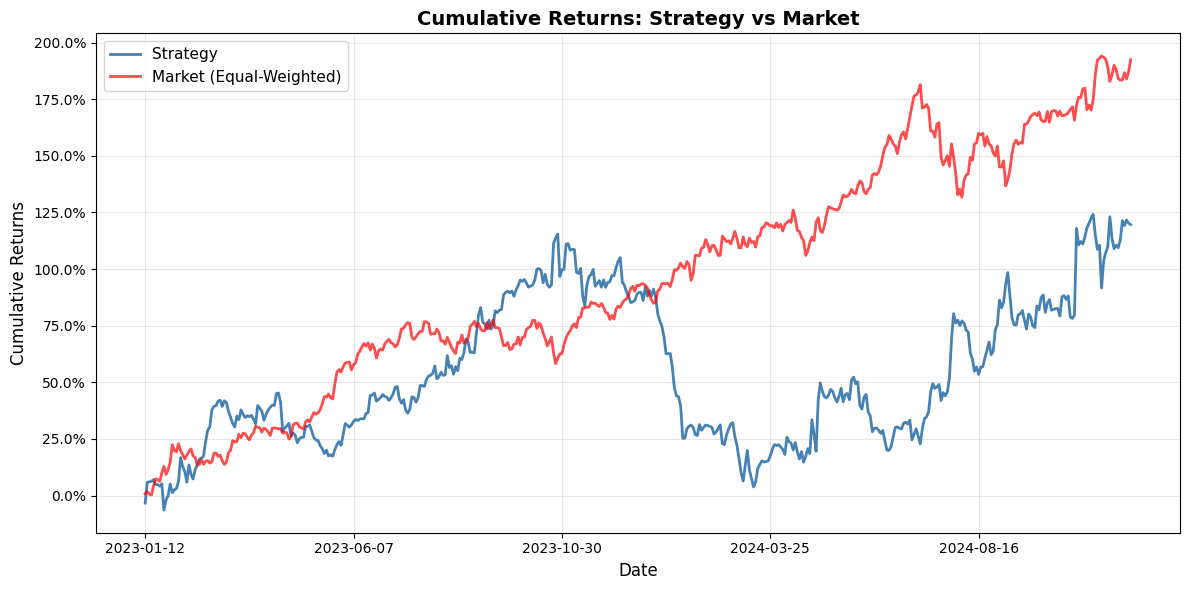

Strategy Total Return: 119.65%
Market Total Return: 192.46%
Strategy Sharpe Ratio: 1.07
Market Sharpe Ratio: 2.43


In [41]:
# Calculate cumulative returns for strategy
cumulative_strategy_returns = (1 + strategy_returns).cumprod() - 1

# Calculate market benchmark 
market_returns = actuals_unstacked.mean(axis=1)  
cumulative_market_returns = (1 + market_returns).cumprod() - 1

plt.figure(figsize=(12, 6))

cumulative_strategy_returns.plot(label='Strategy', color='steelblue', linewidth=2)
cumulative_market_returns.plot(label='Market (Equal-Weighted)', color='red', alpha=0.7, linewidth=2)

plt.title('Cumulative Returns: Strategy vs Market', fontsize=14, fontweight='bold')
plt.ylabel('Cumulative Returns', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Strategy Total Return: {cumulative_strategy_returns.iloc[-1]:.2%}")
print(f"Market Total Return: {cumulative_market_returns.iloc[-1]:.2%}")
print(f"Strategy Sharpe Ratio: {strategy_returns.mean() / strategy_returns.std() * np.sqrt(252):.2f}")
print(f"Market Sharpe Ratio: {market_returns.mean() / market_returns.std() * np.sqrt(252):.2f}")

### Lasso Regression

In [35]:
lasso_alphas = np.logspace(-4, 4, 9)
lasso_alphas = sorted(list(lasso_alphas) + list(lasso_alphas * 5))

In [36]:
lasso_alphas

[np.float64(0.0001),
 np.float64(0.0005),
 np.float64(0.001),
 np.float64(0.005),
 np.float64(0.01),
 np.float64(0.05),
 np.float64(0.1),
 np.float64(0.5),
 np.float64(1.0),
 np.float64(5.0),
 np.float64(10.0),
 np.float64(50.0),
 np.float64(100.0),
 np.float64(500.0),
 np.float64(1000.0),
 np.float64(5000.0),
 np.float64(10000.0),
 np.float64(50000.0)]

In [37]:
lasso_coeffs, lasso_scores, lasso_predictions = {}, [], []

for alpha in lasso_alphas:
    print(alpha, end = ' ', flush=True)
    start = time()
    model = Lasso(alpha=alpha,
                  fit_intercept=False,
                  random_state=42)

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

    coeffs = []
    for (train_idx, test_idx) in cv.split(X_train):
        X_curr_train, y_curr_train = X_train.iloc[train_idx], y_train[target].iloc[train_idx]
        X_curr_test, y_curr_test = X_train.iloc[test_idx], y_train[target].iloc[test_idx]

        pipe.fit(X=X_curr_train, y=y_curr_train)
        y_pred = pipe.predict(X_curr_test)

        preds_lasso = y_curr_test.to_frame('actuals').assign(predicted=y_pred)
        preds_by_day_lasso = preds.groupby(level='date')
        scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted,
                                                                   x.actuals)[0] * 100)
                            .to_frame('ic'),
                            preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted,
                                                                                    y_true=x.actuals)))
                            .to_frame('rmse')], axis=1)

        lasso_scores.append(scores.assign(alpha=alpha))
        lasso_predictions.append(preds.assign(alpha=alpha))

        coeffs.append(pipe.named_steps['model'].coef_)
    lasso_coeffs[alpha] = np.mean(coeffs, axis=0)

print('\n')

0.0001 0.0005 0.001 0.005 0.01 0.05 

KeyboardInterrupt: 

In [ ]:
lasso_scores = pd.concat(lasso_scores)
lasso_scores

,ic,rmse,alpha
date,,,
2022-12-28,50.108043,0.024536,0.0001
2022-12-29,-0.542617,0.004968,0.0001
2022-12-30,-28.412965,0.022500,0.0001
2023-01-03,-28.192077,0.023408,0.0001
2023-01-04,-29.594238,0.016087,0.0001
...,...,...,...
2023-01-05,-14.871549,0.030560,50000.0000
2023-01-06,18.501801,0.021748,50000.0000
2023-01-09,-28.451381,0.016069,50000.0000


In [ ]:
best_alpha_lasso = float(lasso_scores.groupby('alpha').ic.mean().idxmax())
best_alpha_lasso

0.0001

In [ ]:
final_model_lasso = Lasso(alpha=best_alpha_lasso, fit_intercept=False, random_state=42)
final_pipe_lasso = Pipeline([('scaler', StandardScaler()), ('model', final_model_lasso)])
final_pipe_lasso.fit(X=X_train, y=y_train[target])

,steps,"[('scaler', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,alpha,0.0001
,fit_intercept,False
,precompute,False
,copy_X,True


In [ ]:
y_test_pred_lasso = final_pipe_lasso.predict(X_test)

In [ ]:
# Prepare test predictions
test_predictions = y_test[[target]].copy()
test_predictions['predicted'] = y_test_pred_lasso
test_predictions.columns = ['actuals', 'predicted']
test_predictions

actuals  predicted
ticker date                           
MCD    2023-01-12  0.008249   0.000363
       2023-01-13  0.019413  -0.000690
       2023-01-17 -0.029441  -0.001501
       2023-01-18 -0.009247   0.001793
       2023-01-19  0.018969   0.000384
...                     ...        ...
V      2024-11-22  0.010551  -0.001524
       2024-11-25 -0.004374  -0.002176
       2024-11-26  0.009236  -0.001154
       2024-11-27  0.001207  -0.002067
       2024-11-29  0.004983  -0.001527

[23700 rows x 2 columns]

In [ ]:
# Convert to unstacked format for easy ranking
predictions_unstacked = test_predictions['predicted'].unstack('ticker')
actuals_unstacked = test_predictions['actuals'].unstack('ticker')

In [ ]:
# Set portfolio parameters
N_LONG = 5
N_SHORT = 5

# Generate trading signals
long_signals = ((predictions_unstacked
                .where(predictions_unstacked > 0)
                .rank(axis=1, ascending=False) <= N_LONG)
                .astype(int))

short_signals = ((predictions_unstacked
                  .where(predictions_unstacked < 0)
                  .rank(axis=1, ascending=True) <= N_SHORT)
                  .astype(int))

In [ ]:
# Calculate strategy returns
long_returns = (long_signals * actuals_unstacked).sum(axis=1) / long_signals.sum(axis=1)
short_returns = (short_signals * (-actuals_unstacked)).sum(axis=1) / short_signals.sum(axis=1)
strategy_returns = long_returns.fillna(0) + short_returns.fillna(0)

In [ ]:
print(f"Strategy Sharpe Ratio: {strategy_returns.mean() / strategy_returns.std() * np.sqrt(252):.2f}")

Strategy Sharpe Ratio: 1.16


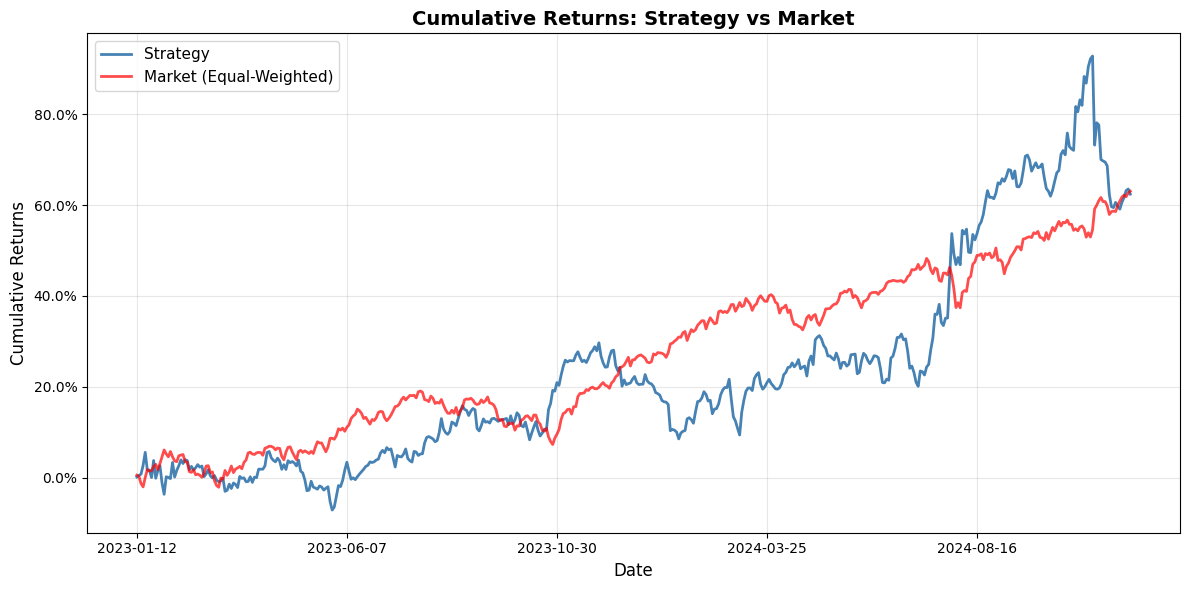

Strategy Total Return: 62.41%
Market Total Return: 63.07%
Strategy Sharpe Ratio: 1.16
Market Sharpe Ratio: 2.11


In [ ]:
# Calculate cumulative returns for strategy
cumulative_strategy_returns = (1 + strategy_returns).cumprod() - 1

# Calculate market benchmark 
market_returns = actuals_unstacked.mean(axis=1)  
cumulative_market_returns = (1 + market_returns).cumprod() - 1

plt.figure(figsize=(12, 6))

cumulative_strategy_returns.plot(label='Strategy', color='steelblue', linewidth=2)
cumulative_market_returns.plot(label='Market (Equal-Weighted)', color='red', alpha=0.7, linewidth=2)

plt.title('Cumulative Returns: Strategy vs Market', fontsize=14, fontweight='bold')
plt.ylabel('Cumulative Returns', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Strategy Total Return: {cumulative_strategy_returns.iloc[-1]:.2%}")
print(f"Market Total Return: {cumulative_market_returns.iloc[-1]:.2%}")
print(f"Strategy Sharpe Ratio: {strategy_returns.mean() / strategy_returns.std() * np.sqrt(252):.2f}")
print(f"Market Sharpe Ratio: {market_returns.mean() / market_returns.std() * np.sqrt(252):.2f}")